# 📊 Data Quality & Advanced Anomaly Detection in Mobility Systems
## COSYS/GRETTIA – Université Gustave Eiffel (TR/EN/FR)

- **TR**: Bu notebook, mobilite verileri üzerinde veri kalitesi değerlendirmesi, ileri seviye anomali tespiti ve modelleme (Auto-parameter tuning/hyperparameter optimization) içeren kapsamlı bir çalışma sunar.
- **EN**: This notebook presents a comprehensive study on data quality assessment, advanced anomaly detection, and modeling with auto-parameter tuning for mobility data.
- **FR**: Ce notebook présente une étude complète sur l’évaluation de la qualité des données, la détection avancée d’anomalies et la modélisation avec réglage automatique des hyperparamètres pour les données de mobilité.

---
**Keywords**: Data Quality, Anomaly Detection, AI, Auto-parameter tuning, Hyperparameter Optimization, Mobility & Transportation


In [1]:
# CELL 1: Libraries & setup (TR/EN/FR)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import warnings; warnings.filterwarnings('ignore')
np.random.seed(42); plt.style.use('default'); sns.set_palette('husl')
print('Libraries ready / Kütüphaneler hazır / Bibliothèques prêtes')


Libraries ready / Kütüphaneler hazır / Bibliothèques prêtes


In [2]:
# CELL 2: Load data & quality overview (TR/EN/FR)
data = pd.read_csv('anomalies_detected.csv')
print('Shape:', data.shape)
print('Columns:', list(data.columns))
print('Missing values:\n', data.isnull().sum())
print('\nDescribe:\n', data.describe())

# Basic cleaning views
numeric_cols = ['trip_duration_min','speed_kmh']
missing_pct = data.isnull().mean()*100
q_summary = {}
for col in numeric_cols:
    q1, q3 = data[col].quantile([0.25,0.75])
    iqr = q3-q1
    q_summary[col] = dict(q1=float(q1), q3=float(q3), iqr=float(iqr))
print('\nIQR summary:', q_summary)


Shape: (500, 7)
Columns: ['trip_duration_min', 'speed_kmh', 'latitude', 'longitude', 'anomaly_zscore', 'anomaly_iqr', 'anomaly_isolation']
Missing values:
 trip_duration_min    2
speed_kmh            1
latitude             0
longitude            0
anomaly_zscore       0
anomaly_iqr          0
anomaly_isolation    0
dtype: int64

Describe:
        trip_duration_min   speed_kmh    latitude   longitude
count         498.000000  499.000000  500.000000  500.000000
mean           30.282957   40.435762   48.782231    2.553136
std             7.020100   10.952668    1.738650    4.368306
min             1.000000  -10.000000   10.000000    2.322796
25%            26.468673   35.214484   48.850544    2.346081
50%            30.085014   40.229959   48.857725    2.352326
75%            33.252328   45.218267   48.864147    2.359286
max           120.000000  200.000000   50.000000  100.000000

IQR summary: {'trip_duration_min': {'q1': 26.46867313658288, 'q3': 33.25232786502261, 'iqr': 6.7836547284397

In [3]:
# CELL 3: Impute, standardize & baseline anomaly flags
imputer = SimpleImputer(strategy='median')
data_imp = pd.DataFrame(imputer.fit_transform(data[numeric_cols]), columns=numeric_cols, index=data.index)
scaler = StandardScaler()
data_std = scaler.fit_transform(data_imp.values)

# Traditional methods
def zscore_flags(df, thr=3.0):
    z = np.abs(stats.zscore(df))
    return (z>thr).any(axis=1)

def iqr_flags(df):
    Q1 = df.quantile(0.25); Q3 = df.quantile(0.75); IQR = Q3-Q1
    return ((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)

z_flags = zscore_flags(data_imp)
iqr_f = iqr_flags(data_imp)
iso = IsolationForest(random_state=42, contamination=0.1)
iso_pred = iso.fit_predict(data_imp)
iso_flags = pd.Series(iso_pred==-1, index=data_imp.index)

# Ensemble voting (boolean OR + vote sum later)
ensemble_any = z_flags | iqr_f | iso_flags
print('Counts -> Z:', z_flags.sum(), 'IQR:', iqr_f.sum(), 'IF:', iso_flags.sum(), 'Any:', ensemble_any.sum())


Counts -> Z: 6 IQR: 16 IF: 50 Any: 50


In [4]:
# CELL 4: DBSCAN & PCA anomaly scoring
pca = PCA(n_components=2).fit(data_std)
X_pca = pca.transform(data_std)
X_rec = pca.inverse_transform(X_pca)
recon_err = np.mean((data_std - X_rec)**2, axis=1)
re_thr = np.percentile(recon_err, 95)
pca_flags = recon_err > re_thr

clust = DBSCAN(eps=0.5, min_samples=5).fit(data_std)
db_flags = clust.labels_ == -1

votes = z_flags.astype(int) + iqr_f.astype(int) + iso_flags.astype(int) + pca_flags.astype(int) + db_flags.astype(int)
print('PCA outliers:', int(pca_flags.sum()), 'DBSCAN outliers:', int(db_flags.sum()), 'Fusion votes>=3:', int((votes>=3).sum()))


PCA outliers: 24 DBSCAN outliers: 11 Fusion votes>=3: 12


In [5]:
# CELL 5: Hyperparameter optimization (IF & RF)
X = pd.DataFrame(data_std, columns=numeric_cols)
y = (votes>=3).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

iso_grid = GridSearchCV(IsolationForest(random_state=42),
                        {'n_estimators':[50,100,200], 'contamination':[0.05,0.1,0.15], 'max_samples':['auto',100,200]},
                        cv=3, scoring='roc_auc', n_jobs=-1)
iso_grid.fit(X_train, y_train)
print('Best IF:', iso_grid.best_params_)

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       {'n_estimators':[100,200], 'max_depth':[5,10,None], 'min_samples_split':[2,5,10]},
                       cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('Best RF:', rf_grid.best_params_)


Best IF: {'contamination': 0.05, 'max_samples': 100, 'n_estimators': 50}
Best RF: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


IF -> acc: 0.9 prec: 0.16666666666666666 rec: 1.0 f1: 0.2857142857142857
RF -> acc: 0.9933333333333333 prec: 1.0 rec: 0.6666666666666666 f1: 0.8


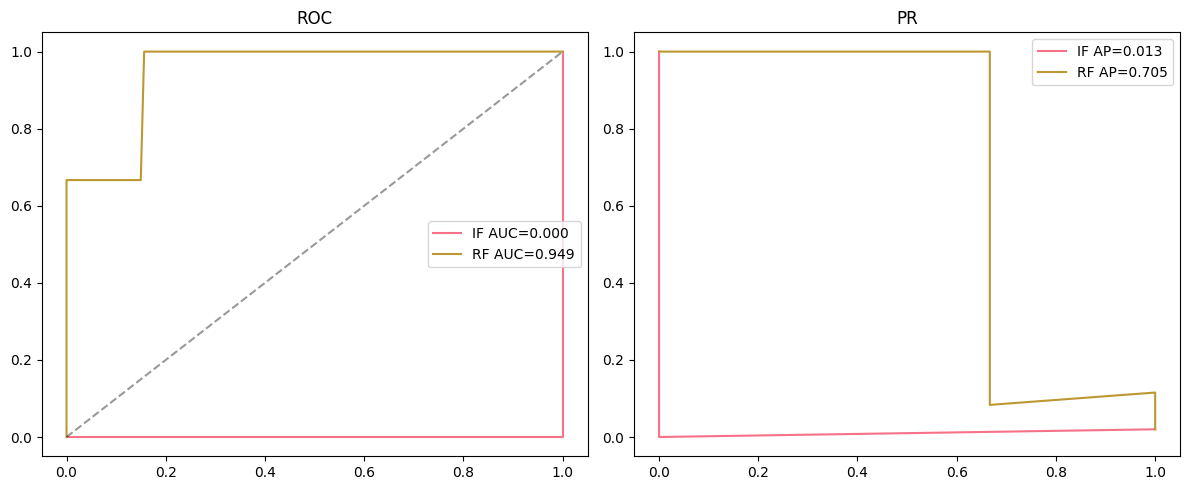

In [6]:
# CELL 6: Evaluation & curves
best_iso = iso_grid.best_estimator_
best_rf = rf_grid.best_estimator_

iso_scores = best_iso.decision_function(X_test)
rf_prob = best_rf.predict_proba(X_test)[:,1]
rf_pred = best_rf.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
iso_pred_bin = (best_iso.predict(X_test)==-1).astype(int)
print('IF -> acc:', accuracy_score(y_test, iso_pred_bin), 'prec:', precision_score(y_test, iso_pred_bin), 'rec:', recall_score(y_test, iso_pred_bin), 'f1:', f1_score(y_test, iso_pred_bin))
print('RF -> acc:', accuracy_score(y_test, rf_pred), 'prec:', precision_score(y_test, rf_pred), 'rec:', recall_score(y_test, rf_pred), 'f1:', f1_score(y_test, rf_pred))

fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_scores)
precision_iso, recall_iso, _ = precision_recall_curve(y_test, iso_scores)
roc_auc_iso = auc(fpr_iso, tpr_iso)
ap_iso = average_precision_score(y_test, iso_scores)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
ap_rf = average_precision_score(y_test, rf_prob)

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(fpr_iso, tpr_iso, label=f'IF AUC={roc_auc_iso:.3f}')
axes[0].plot(fpr_rf, tpr_rf, label=f'RF AUC={roc_auc_rf:.3f}')
axes[0].plot([0,1],[0,1],'k--', alpha=0.4); axes[0].legend(); axes[0].set_title('ROC')
axes[1].plot(recall_iso, precision_iso, label=f'IF AP={ap_iso:.3f}')
axes[1].plot(recall_rf, precision_rf, label=f'RF AP={ap_rf:.3f}')
axes[1].legend(); axes[1].set_title('PR')
plt.tight_layout(); plt.show()


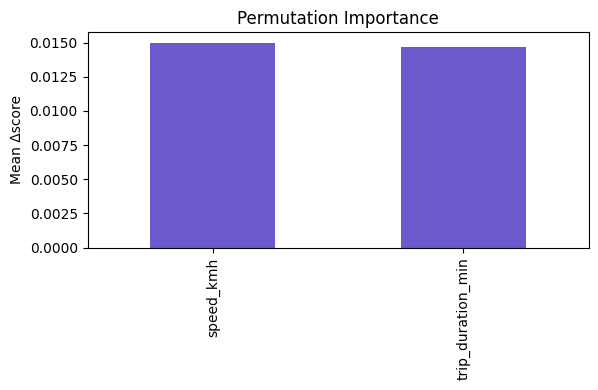

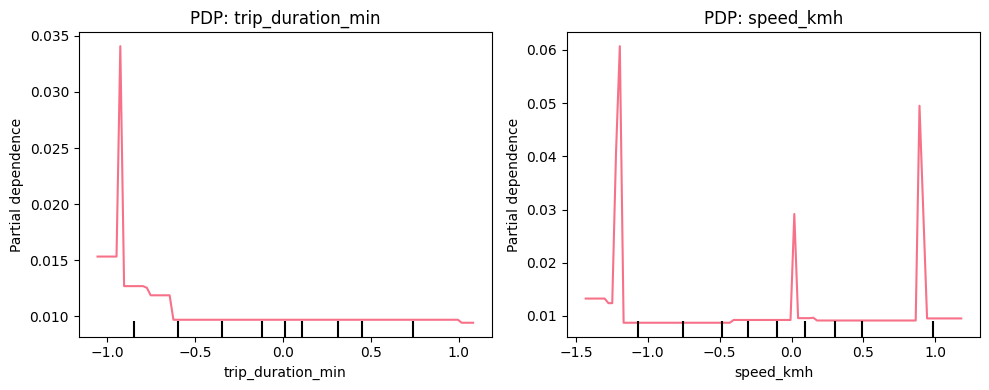

In [7]:
# CELL 7: Feature importance & PDP (RF)
result = permutation_importance(best_rf, X_test, y_test, n_repeats=20, random_state=42)
pi = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
ax = pi.plot(kind='bar', color='slateblue', figsize=(6,4), title='Permutation Importance'); ax.set_ylabel('Mean Δscore'); plt.tight_layout(); plt.show()
fig, ax = plt.subplots(1,2, figsize=(10,4))
PartialDependenceDisplay.from_estimator(best_rf, X_test, [0], ax=ax[0]); ax[0].set_title(f'PDP: {X_test.columns[0]}')
PartialDependenceDisplay.from_estimator(best_rf, X_test, [1], ax=ax[1]); ax[1].set_title(f'PDP: {X_test.columns[1]}')
plt.tight_layout(); plt.show()


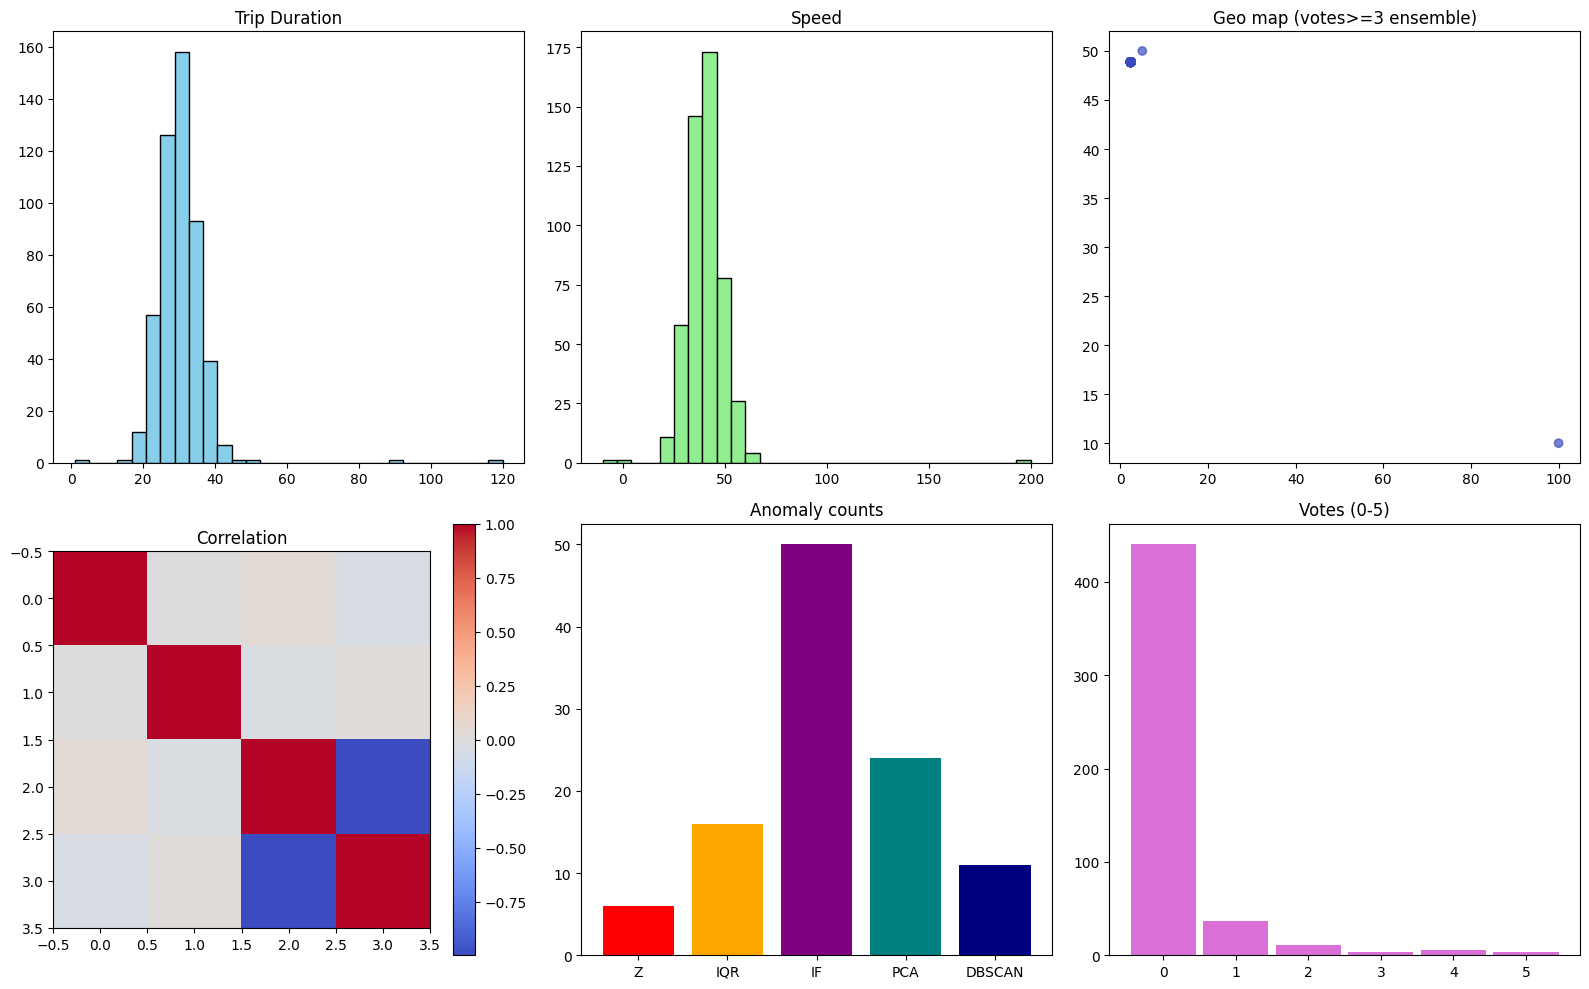

In [8]:
# CELL 8: Visual dashboards (histograms, correlations, geo)
fig, axes = plt.subplots(2,3, figsize=(16,10))
axes[0,0].hist(data['trip_duration_min'].dropna(), bins=30, color='skyblue', edgecolor='black'); axes[0,0].set_title('Trip Duration')
axes[0,1].hist(data['speed_kmh'].dropna(), bins=30, color='lightgreen', edgecolor='black'); axes[0,1].set_title('Speed')
axes[0,2].scatter(data['longitude'], data['latitude'], c=(votes>=3).astype(int), cmap='coolwarm', alpha=0.7); axes[0,2].set_title('Geo map (votes>=3 ensemble)')
corr = data[['trip_duration_min','speed_kmh','latitude','longitude']].corr()
im = axes[1,0].imshow(corr, cmap='coolwarm'); axes[1,0].set_title('Correlation'); plt.colorbar(im, ax=axes[1,0])
axes[1,1].bar(['Z','IQR','IF','PCA','DBSCAN'], [z_flags.sum(), iqr_f.sum(), iso_flags.sum(), int(pca_flags.sum()), int(db_flags.sum())], color=['r','orange','purple','teal','navy'])
axes[1,1].set_title('Anomaly counts')
axes[1,2].hist(votes, bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9, color='orchid'); axes[1,2].set_xticks([0,1,2,3,4,5]); axes[1,2].set_title('Votes (0-5)')
plt.tight_layout(); plt.show()


### 📌 Guidance (TR/EN/FR)
- TR: Hücreleri sırayla çalıştırın. Çıktılar notebook içinde görselleştirilecektir.
- EN: Run cells in order; outputs will be visualized inline.
- FR: Exécutez les cellules dans l’ordre; les sorties seront visualisées dans le notebook.


# 🧠 Explanations for All Code and Visualizations (TR/EN/FR)

## Cell 1 – Libraries & Setup
- TR: Bu hücre, veri işleme, modelleme ve görselleştirme için gerekli kütüphaneleri yükler. Uyarılar susturulur, rastgelelik kontrolü için seed atanır.
- EN: Loads required libraries for data processing, modeling, and visualization. Suppresses warnings and sets the seed for reproducibility.
- FR: Charge les bibliothèques nécessaires pour le traitement, la modélisation et la visualisation. Supprime les avertissements et fixe la graine pour la reproductibilité.

## Cell 2 – Data Loading & Quality Overview
- TR: Veri boyutu, sütunlar, eksik değerler ve temel istatistikler raporlanır. IQR hesaplanır; aykırı değer eşiği belirleme için kullanılır.
- EN: Reports shape, columns, missing values, and basic statistics. Computes IQR; used to define outlier thresholds.
- FR: Rapporte la taille, les colonnes, les valeurs manquantes et les statistiques de base. Calcule l’IQR; utilisé pour définir les seuils d’anomalies.

## Cell 3 – Median Imputation, Scaling, Baseline Flags (Z/IQR/IF)
- TR: Eksik veriler medyanla doldurulur (robust), `StandardScaler` ile ölçeklenir. Z-Score (|Z|>3), IQR (çit dışı), Isolation Forest (ayrık gözlemleri izolasyonla yakalar) bayrakları oluşturulur.
- EN: Fills missing values with median (robust), standardizes features. Creates anomaly flags via Z-Score (|Z|>3), IQR (beyond whiskers), Isolation Forest (isolates rare points).
- FR: Imputation médiane (robuste), standardisation. Crée des indicateurs d’anomalies via Z-Score (|Z|>3), IQR (au-delà des moustaches), Isolation Forest (isole les points rares).
- Neden/Why/Pourquoi: Farklı yöntemler farklı anomali tiplerine duyarlıdır; çoklu bakış güvenilirlik sağlar.

## Cell 4 – PCA Reconstruction Error, DBSCAN, Ensemble Votes
- TR: PCA ile yeniden inşa hatası (95. persentil üzerinde anormal), DBSCAN ile yoğunluk-dışı noktalar tespit edilir. 5 yöntemin oyları toplanır; votes≥3 güçlü anomali.
- EN: PCA reconstruction error (above 95th percentile) and DBSCAN (density-based outliers). Ensemble of 5 methods; votes≥3 indicates strong anomalies.
- FR: Erreur de reconstruction PCA (au-dessus du 95e percentile) et DBSCAN (anomalies basées sur la densité). Vote d’ensemble de 5 méthodes; votes≥3 = anomalies fortes.
- Neden/Why/Pourquoi: Lineer (PCA) ve yoğunluk tabanlı (DBSCAN) bakış açılarını birleştirmek kapsamı genişletir.

## Cell 5 – Hyperparameter Optimization (IF & RF)
- TR: `GridSearchCV` ile IF (n_estimators, contamination, max_samples) ve RF (n_estimators, max_depth, min_samples_split) ayarlanır.
- EN: Tunes IF and RF via `GridSearchCV` over key parameters.
- FR: Ajuste IF et RF via `GridSearchCV` sur les paramètres clés.
- Neden/Why/Pourquoi: Doğru hiperparametreler hatalı alarmı azaltır ve yakalama oranını artırır.

## Cell 6 – Evaluation, ROC & PR Curves
- TR: IF (skor→etikete eşik), RF (olasılık) için doğruluk, kesinlik, geri çağırma, F1 raporlanır. ROC-AUC ve PR eğrileri sınıf dengesizliğine duyarlı analiz sunar.
- EN: Reports accuracy, precision, recall, F1. ROC-AUC and Precision-Recall curves visualize ranking quality, robust under imbalance.
- FR: Rapporte accuracy, précision, rappel, F1. ROC-AUC et courbes PR visualisent la qualité du classement, robustes en cas de déséquilibre.
- Neden/Why/Pourquoi: Anomali tespitinde PR eğrileri özellikle yararlıdır (pozitif sınıf nadir).

## Cell 7 – Permutation Importance & Partial Dependence (RF)
- TR: Özellik önemini permütasyonla ölçer (model agnostik). PDP ile tekil değişkenin karar üzerindeki marjinal etkisini görselleştirir.
- EN: Model-agnostic permutation importance; PDP visualizes marginal effect of each feature on the prediction.
- FR: Importance par permutation (agnostique), PDP illustre l’effet marginal de chaque variable.
- Neden/Why/Pourquoi: Açıklanabilirlik, alan uzmanlarına güven ve içgörü sağlar.

## Cell 8 – Visual Dashboards (Hist/Correlation/Geo + Ensemble)
- TR: Dağılımlar aykırıların kuyruk davranışını, korelasyon matrisi ilişkileri, coğrafi harita (votes≥3) uzamsal kümelenmeyi gösterir.
- EN: Distributions show tail behavior, correlation matrix shows relationships, geo map (votes≥3) shows spatial clustering of anomalies.
- FR: Les distributions montrent les queues, la matrice de corrélation les relations, la carte géo (votes≥3) la concentration spatiale des anomalies.
- Neden/Why/Pourquoi: Görsel özetler kalite problemlerinin kök nedenine dair hızlı ipuçları verir.

## Methodological Rationale (Short)
- TR: Birden çok yöntem (Z/IQR/IF/PCA/DBSCAN) ve oy birleştirme, tek yöntemin kör noktalarını kapatır.
- EN: Multi-method ensemble closes blind spots of any single detector.
- FR: L’ensemble multi‑méthodes comble les angles morts d’un détecteur unique.

